<a href="https://colab.research.google.com/github/Zulfa-Varvani/ML-things/blob/main/Cruise_crew_size_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from google.colab import files
uploaded = files.upload()

Saving cruise_ship_info.csv to cruise_ship_info (1).csv


In [ ]:
import io
#read file and display columns
data = pd.read_csv(io.BytesIO(uploaded['cruise_ship_info.csv']))
data.head()

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00


In [ ]:
data.describe()
#Build a regressor that recommends the “crew” size for potential ship buyers.

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,15.689873,71.284671,18.457405,8.130633,8.830000,39.900949,7.794177
std,7.615691,37.229540,9.677095,1.793474,4.471417,8.639217,3.503487
min,4.000000,2.329000,0.660000,2.790000,0.330000,17.700000,0.590000
25%,10.000000,46.013000,12.535000,7.100000,6.132500,34.570000,5.480000
50%,14.000000,71.899000,19.500000,8.555000,9.570000,39.085000,8.150000
75%,20.000000,90.772500,24.845000,9.510000,10.885000,44.185000,9.990000
max,48.000000,220.000000,54.000000,11.820000,27.000000,71.430000,21.000000


In [ ]:
#calculate basic statistics of data (mean, sum, max, min, count, median, std, var), examine data, and state observations

def data_stats(col):
  if data[col].dtype == object and isinstance(data.iloc[0][col],str):
    count = data[col].count()
    mean = sum = max = min = med = std = var = 'NA'
  else:
    mean = data[col].mean()
    sum = data[col].sum()
    max = data[col].max()
    min = data[col].min()
    count = data[col].count()
    med = data[col].median()
    std = data[col].std()
    var = data[col].var()
  stat_col = np.array([mean, sum, max, min, count, med, std, var])
  return stat_col

stats = pd.DataFrame(np.nan, index=['Mean', 'Sum', 'Max', 'Min', 'Count', 'Median', 'Standard Deviation', 'Variation'],
                          columns=['Ship_name', 'Cruise_line', 'Age', 'Tonnage', 'passengers', 'length', 'cabins', 'passenger_density', 'crew'])
for col in stats:
  stats[col]= data_stats(col)

stats

#average age of ships was 16 years old from the 158 entries
#passenger density was averaged to 40 and about 8 crew members
#average tonnage was 71 and average number of cabins was about 9
#average length of ships 8.13

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
Mean,NA,NA,15.689873,71.284671,18.457405,8.130633,8.830000,39.900949,7.794177
Sum,NA,NA,2479.000000,11262.978000,2916.270000,1284.640000,1395.140000,6304.350000,1231.480000
Max,NA,NA,48.000000,220.000000,54.000000,11.820000,27.000000,71.430000,21.000000
Min,NA,NA,4.000000,2.329000,0.660000,2.790000,0.330000,17.700000,0.590000
Count,158,158,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
Median,NA,NA,14.000000,71.899000,19.500000,8.555000,9.570000,39.085000,8.150000
Standard Deviation,NA,NA,7.615691,37.229540,9.677095,1.793474,4.471417,8.639217,3.503487
Variation,NA,NA,57.998750,1386.038651,93.646163,3.216547,19.993572,74.636072,12.274418


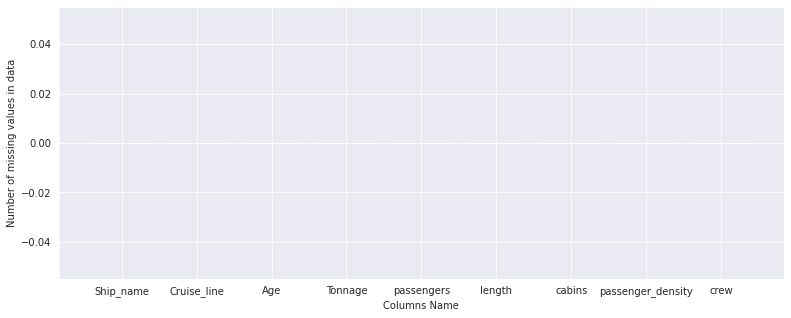

In [ ]:
#check if data is missing any values

plt.figure(figsize=(13,5))
plt.bar(data.columns,data.isna().sum())
plt.xlabel('Columns Name')
plt.ylabel('Number of missing values in data')
plt.show()

#no missing values in data set

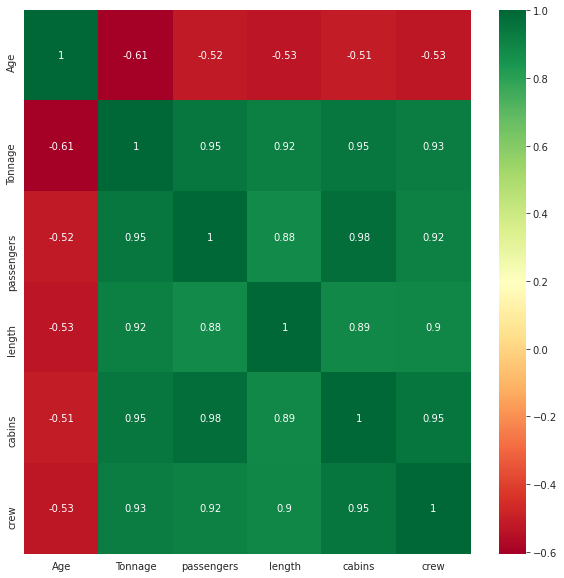

In [ ]:
corr = data.corr()
top_corr = corr.index[abs(corr['crew'])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(data[top_corr].corr(),annot=True,cmap='RdYlGn')

In [ ]:
#from the correlation graph above, age, ship name, passenger_density, and cruise line have little to no correlation to crew size, so these values are removed. 
#tonnage, passengers, length, and cabins is more likely important in determining crew size

pred_data = data.drop(['Ship_name', 'Cruise_line', 'Age', 'passenger_density'], axis=1)
pred_data.head()

,Tonnage,passengers,length,cabins,crew
0,30.277,6.94,5.94,3.55,3.55
1,30.277,6.94,5.94,3.55,3.55
2,47.262,14.86,7.22,7.43,6.70
3,110.000,29.74,9.53,14.88,19.10
4,101.353,26.42,8.92,13.21,10.00


In [ ]:
#one hot encoding for categorical features

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

enc= OneHotEncoder(handle_unknown='ignore')
enc_data = pd.DataFrame(enc.fit_transform(data[['Ship_name', 'Cruise_line']]).toarray())

enc_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Create training and testing sets (use 60% of the data for the training and reminder for testing)
#not using data from removed features

from sklearn import linear_model
from sklearn.model_selection import train_test_split

x = pred_data.drop(['crew'],axis=1)
y = pred_data.crew

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.4)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
y_train.head()

(94, 4) (94,)
(64, 4) (64,)


85      9.59
103    11.00
33      6.70
11      6.60
9      11.50
Name: crew, dtype: float64

Score:  0.9106878605268542


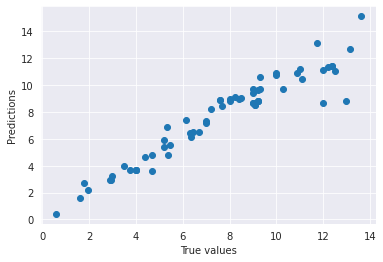

In [ ]:
#Build a machine learning model to predict the ‘crew’ size.

lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
pred = lm.predict(X_test)

plt.scatter(y_test,pred)
plt.ylabel('Predictions')
plt.xlabel('True values')
print('Score: ', model.score(X_test, y_test))

In [ ]:
#Pearson correlation coefficient for the training set and testing data sets.
from scipy.stats import pearsonr

corr, _ = pearsonr(y_test, pred)
print('Pearsons correlation: %.3f' %corr)

Pearsons correlation: 0.954


In [ ]:
#features chosen as pre processing, but are not considered as hyperparameters: tonnage, passengers, length, and cabins
#standard linear regression used
#would try different models and tune hyper parameters (leaf nodes, lambda, learning rate etc) to improve accuracy

In [ ]:
#regularization is a form of regression and discourages learning more complex/flexible model to avoid overfitting
#in linear regression, this is lambda parameter in the cost function